# Inteligência Artificial Aplicada a Finanças

# Projeto 3 - Otimização Avançada de Portfólio com IA

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


![title](imagens/projeto3.png)

## Parte 3 - Construção do Modelo de Deep Reinforcement Learning

### Instalando e Carregando Pacotes

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# Instala o pacote tensorflow
!pip install -q tensorflow

In [4]:
# Instala o pacote tensorflow-addons
!pip install -q tensorflow-addons

In [5]:
# Imports
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import keras
import tqdm
%matplotlib inline

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

keras      2.4.3
tqdm       4.45.0
matplotlib 3.2.1
pandas     1.1.3
numpy      1.19.2
tensorflow 2.2.0
seaborn    0.10.1
Data Science Academy


In [7]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Arquitetura do Modelo de Deep Reinforcement Learning

http://deeplearningbook.com.br/o-que-e-aprendizagem-por-reforco/

https://pdfs.semanticscholar.org/f911/e718234648d123fbccf712d1b8d22aab53bd.pdf

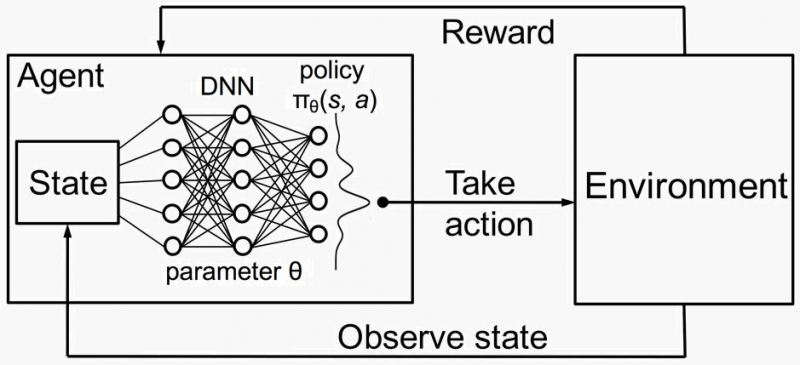

In [8]:
from IPython.display import Image
Image("imagens/imagem1.png")

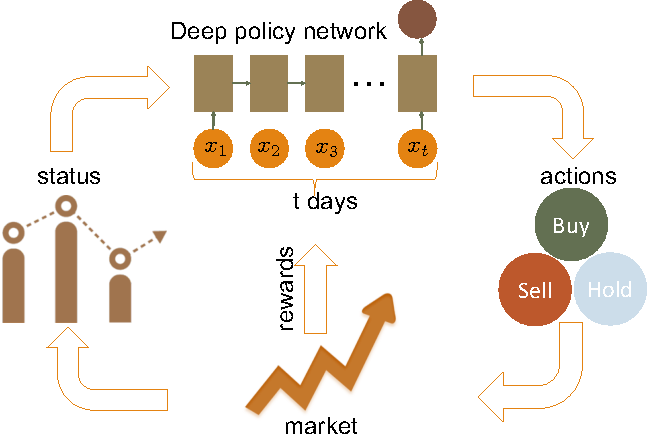

In [9]:
from IPython.display import Image
Image("imagens/imagem2.png")

## Classes do Modelo de Deep Reinforcement Learning

Criaremos 3 classes principais para este projeto:

- EnvRL - Ambiente do Agente Inteligente
- PoliticaLSTM - Política de Recompensa do Agente Inteligente
- PoliticaCNN - Política de Recompensa do Agente Inteligente

### Classe Para o Ambiente de Negociação RL

In [10]:
# Classe do ambiente
class EnvRL():

    # Construtor da Classe
    def __init__(self,
                 Path,
                 PortfolioValue = 10000,
                 TransCost = 0.0025,
                 ReturnRate = 0.02/250,
                 WindowSize = 50,
                 TrainTestSplit = 0.7):


        # Carregando o conjunto de dados
        self.Dataset = np.load(Path)

        # Número de ações e valores associados como Close, High, Low
        self.NumStocks = self.Dataset.shape[1]
        self.NumValues = self.Dataset.shape[0]

        # Inicializando parâmetros
        self.PortfolioValue = PortfolioValue
        self.TransCost = TransCost
        self.ReturnRate = ReturnRate
        self.WindowSize = WindowSize
        self.Done = False

        # Estado inicial, ação, término
        self.state = None
        self.TimeLength = None
        self.Terminate = False

        # Cutoff (quando terminamos, ou seja, quando concluirmos o processamento das linhas do dataset)
        self.TerminateRows = int((self.Dataset.shape[2] - self.WindowSize) * TrainTestSplit)

    # Array para a taxa de retorno
    def UpdatedOpenValues(self, T):
        return np.array([1 + self.ReturnRate] + self.Dataset[-1,:,T].tolist())

    # Tensor de entrada (menos o tamanho da janela)
    def InputTensor(self, Tensor, T):
        return Tensor[: , : , T - self.WindowSize:T]

    # Reset do ambiente
    def ResetEnvironment(self, InitWeight, InitPortfolio, T):
        self.state = (self.InputTensor(self.Dataset, self.WindowSize) , InitWeight , InitPortfolio)
        self.TimeLength = self.WindowSize + T
        self.Done = False

        return self.state, self.Done

    # Aqui, obtemos a ação que precisa ser executada na etapa t, para obter um novo vetor de peso,
    # função de recompensa e valor atualizado do portfólio.
    # Obtemos os valores do tensor de entrada para o timestep te para um determinado tamanho de janela para
    # cada uma das ações.
    # O estado geralmente contém um tensor de entrada, vetor de peso, vetor de portfólio.
    def Step(self, Action):

        # Tensor de entrada
        Dataset = self.InputTensor(self.Dataset, self.index)

        # Valores do estado atual - vetor de peso atual e vetor de portfólio
        weight_vector_old = self.state[1]
        portfolio_value_old = self.state[2]

        # Atualize o vetor com valores de abertura
        NewOpenValues = self.UpdatedOpenValues(index)

        # O agente de trading aqui fornece novas ações, ou seja, um novo vetor de peso para as novas alocações que
        # precisam ser feitas
        WeightAllocation = Action
        PortfolioAllocation = portfolio_value_old

        # Ao alocar carteiras usando pesos, teremos que contabilizar as taxas de transação ou comissão
        TransactionCost = PortfolioAllocation * self.TransCost * np.linalg.norm((WeightAllocation - weight_vector_old), 
                                                                                ord = 1)

        # Para encontrar o novo vetor de peso, precisamos obter o valor do portfólio atual.
        # Para obter o vetor de valor para cada ação, precisamos multiplicar o valor do portfólio pelo vetor de peso.
        # Sempre que um portfólio é atualizado, há um custo de transação adicional que incorre no valor do portfólio.
        ValueAfterTransaction = (PortfolioAllocation * WeightAllocation) - np.array([cost] + [0]*self.nb_stocks)

        # Portanto, a transação custou valores de ações deduzidos no dia anterior,
        # quando multiplicamos esse vetor pelos últimos valores em aberto.
        NewValueofStocks = ValueAfterTransaction * NewOpenValues

        # Quando somamos os preços das ações individuais, obtemos o valor do portfólio.
        NewPortfolioValue = np.sum(NewValueofStocks)

        # Para obter o novo vetor de pesos, dividimos os preços das ações individuais pelo valor total do portfólio
        NewWeightVector = NewValueofStocks / NewPortfolioValue

        # Após cada passo de tempo, o valor do portfólio diminui ou aumenta, dependendo de como o agente executa
        RewardValue = (NewPortfolioValue - portfolio_value_old) / (portfolio_value_old)

        # Atualizamos o índice
        self.index = self.index + 1

        # Usando os valores calculados até agora, podemos criar um novo estado
        self.state = (self.InputTensor(self.Dataset, self.index), NewWeightVector, NewPortfolioValue)

        # Aaqui verificamos se a etapa foi concluída
        if index >= self.TerminateRows:
            self.Done = True

        return self.state, self.RewardValue, self.Done

### Classe Para a Política RL

Usando essa classe, criaremos políticas para a rede LSTM.

In [11]:
# Classe da política
class PolicyLSTM(object):

    # Método construtor
    def __init__(self, ohlc_feature_num, ticker_num, num_trading_periods, sess, optimizer, trading_cost, 
                 cash_bias_init, interest_rate, equiweight_vector, adjusted_rewards_alpha, num_filter_layer):

        # Inicaliza os parâmetros
        self.ohlc_feature_num = ohlc_feature_num
        self.ticker_num = ticker_num
        self.num_trading_periods =  num_trading_periods
        self.trading_cost = trading_cost
        self.cash_bias_init = cash_bias_init
        self.interest_rate = interest_rate
        self.equiweight_vector = equiweight_vector
        self.adjusted_rewards_alpha = adjusted_rewards_alpha
        self.optimizer = optimizer
        self.sess = sess
        self.num_filter_layer = num_filter_layer
        self.layers = 1
        self.lstm_neurons = 20

        # Cria o tensor X_t para os dados
        self.X_t = tf.compat.v1.placeholder(tf.float32, [None, 
                                                         self.ohlc_feature_num, 
                                                         self.ticker_num, 
                                                         self.num_trading_periods])
        
        # Cria o tensor de pesos anteriores
        self.weights_previous_t = tf.compat.v1.placeholder(tf.float32, [None, 
                                                                        self.ticker_num + 1])
        
        # Cria o tensor
        self.pf_previous_t = tf.compat.v1.placeholder(tf.float32, [None, 1])
        
        # Cria o tensor para os retornos diários
        self.daily_returns_t = tf.compat.v1.placeholder(tf.float32, [None, self.ticker_num])
        
        # Tensor do cash bias
        self.cash_bias = tf.compat.v1.get_variable('cash_bias', 
                                                   shape = [1, 1, 1, 1], 
                                                   initializer = tf.compat.v1.constant_initializer(self.cash_bias_init))
        
        # Define o Shape de X_t
        self.shape_X_t = tf.shape(input = self.X_t)[0]
        
        # Define o cash bias
        self.cash_bias = tf.tile(self.cash_bias, tf.stack([self.shape_X_t, 1, 1, 1]))
        
        # Define a camada LSTM
        self.lstm_layer = self.lstm(self.X_t)
        
        # Define ações escolhidas
        self.action_chosen = self.policy_output(self.lstm_layer, self.cash_bias)
        
        # Recomenpensa ajustada
        self.adjusted_reward = self.reward(shape_X_t, 
                                           self.action_chosen, 
                                           self.interest_rate, 
                                           self.weights_previous_t, 
                                           self.pf_previous_t, 
                                           self.daily_returns_t, 
                                           self.trading_cost)
        
        # Operação de otimizaçãoo
        self.train_op = self.optimizer.minimize(-self.adjusted_reward)

    # Método para criar o modelo LSTM
    # Aqui vamos definir oo aprendizado da  política
    def lstm(self, X_t):
        
        # Define a rede
        network = tf.transpose(a = X_t, perm = [0, 1, 3, 2])
        network = network / network[:, :, -1, 0, None, None]

        # Loop pelas camadas
        for layer_number in range(self.layers):
            
            # Lista de resultado
            resultlist = []
            
            # Não reusar a camada
            reuse = False

            # Loop pelo número de tickers
            for i in range(self.ticker_num):
                if i > 0:
                    reuse = True

                # Gera um resultado (uma camada)
                result = tf.keras.layers.LSTM(X_t[:,:,:, i],
                                              self.lstm_neurons,
                                              dropout = 0.3,
                                              activation = tf.nn.relu)

                # Append do resultado
                resultlist.append(result)
                    
            # Monta a rede
            network = tf.stack(resultlist)
            network = tf.transpose(a = network, perm = [1, 0, 2])
            network = tf.reshape(network, [-1, 1, self.ticker_num, self.lstm_neurons])
            
        return network

    # Método para output da política
    # Aqui teremos as previsões finais a partir do aprendizado da política
    def policy_output(self, network, cash_bias):
        with tf.compat.v1.variable_scope("Convolution_Layer"):
            
            # Camadas da rede neural convolucional
            self.conv = tf.compat.v1.layers.conv2d(inputs = network,
                                                   activation = tf.nn.relu,
                                                   filters = 1,
                                                   strides = (num_filter_layer + 1, 1),
                                                   kernel_size = (1, 1),
                                                   padding = 'same')

        # Ajusta o shape do tensor e aplica função softmax para as previsões finais
        with tf.compat.v1.variable_scope("Policy-Output"):
            tensor_squeeze = tf.squeeze(tf.concat([cash_bias, self.conv], axis = 2), [1,3])
            self.action = tf.nn.softmax(tensor_squeeze)
            
        return self.action

    # Método para a recompensa
    def reward(self, shape_X_t, action_chosen, interest_rate, weights_previous_t, pf_previous_t, 
               daily_returns_t, trading_cost):

        # Cálculo de recompensa para o portfólio atual
        with tf.compat.v1.variable_scope("Reward"):
            
            # Cash return
            cash_return = tf.tile(tf.constant(1 + interest_rate, shape = [1, 1]), tf.stack([shape_X_t, 1]))
            y_t = tf.concat([cash_return, daily_returns_t], axis = 1)
            
            # Vetor de memória
            pf_vector_t = action_chosen * pf_previous_t
            pf_vector_previous = weights_previous_t * pf_previous_t

            # Custo de trading
            total_trading_cost = trading_cost * tf.norm(tensor = pf_vector_t - pf_vector_previous, 
                                                        ord = 1, axis = 1) * tf.constant(1.0, shape = [1])
            
            total_trading_cost = tf.expand_dims(total_trading_cost, 1)

            # Vetor de custo
            zero_vector = tf.tile(tf.constant(np.array([0.0] * ticker_num).reshape(1, ticker_num), 
                                              shape = [1, ticker_num], 
                                              dtype = tf.float32), 
                                  tf.stack([shape_X_t, 1]))
            
            cost_vector = tf.concat([total_trading_cost, zero_vector], axis = 1)

            # Valor do portfólio
            pf_vector_second_t = pf_vector_t - cost_vector
            final_pf_vector_t = tf.multiply(pf_vector_second_t, y_t)
            portfolio_value = tf.norm(tensor = final_pf_vector_t, ord = 1)
            self.instantaneous_reward = (portfolio_value - pf_previous_t) / pf_previous_t

        # Cálculo de recompensa para o portfólio 
        with tf.compat.v1.variable_scope("Reward-Equiweighted"):
            
            cash_return = tf.tile(tf.constant(1 + interest_rate, shape = [1, 1]), tf.stack([shape_X_t, 1]))
            
            y_t = tf.concat([cash_return, daily_returns_t], axis = 1)

            pf_vector_eq = self.equiweight_vector * pf_previous_t

            portfolio_value_eq = tf.norm(tensor = tf.multiply(pf_vector_eq, y_t), ord = 1)
            
            self.instantaneous_reward_eq = (portfolio_value_eq - pf_previous_t) / pf_previous_t

        # Cálculo de recompensas ajustadas
        with tf.compat.v1.variable_scope("Reward-adjusted"):
            self.adjusted_reward = self.instantaneous_reward - self.instantaneous_reward_eq - self.adjusted_rewards_alpha * tf.reduce_max(input_tensor = action_chosen)

        return self.adjusted_reward

    # Calcula os pesos
    def compute_weights(self, X_t_, weights_previous_t_):
        return self.sess.run(tf.squeeze(self.action_chosen), 
                             feed_dict = {self.X_t: X_t_, self.weights_previous_t: weights_previous_t_})

    # Método para o treinamento
    def train_lstm(self, X_t_, weights_previous_t_, pf_previous_t_, daily_returns_t_):
        self.sess.run(self.train_op, feed_dict = {self.X_t: X_t_,
                                                  self.weights_previous_t: weights_previous_t_,
                                                  self.pf_previous_t: pf_previous_t_,
                                                  self.daily_returns_t: daily_returns_t_})

### Classe do Vetor de Memória

In [12]:
# Classe do vetor de memória
class PFVectorMemory(object):

    def __init__(self, ticker_num, beta_pvm, training_steps, training_batch_size, wt_vector_init):

        # PVM total
        self.pvm = np.transpose(np.array([wt_vector_init] * int(training_steps)))
        self.beta_pvm = beta_pvm
        self.training_steps = training_steps
        self.training_batch_size = training_batch_size

    def get_wt_vector_t(self, t):
        return self.pvm[:, t]

    def update_wt_vector_t(self, t, weight):
        self.pvm[:, int(t)] = weight

    def test(self):
        return self.pvm

### Teoria Moderna de Portfólio Usando Teoria de Fronteira Eficiente

Text(0.5, 1.0, 'Retorno Diário dos Ativos Financeiros')

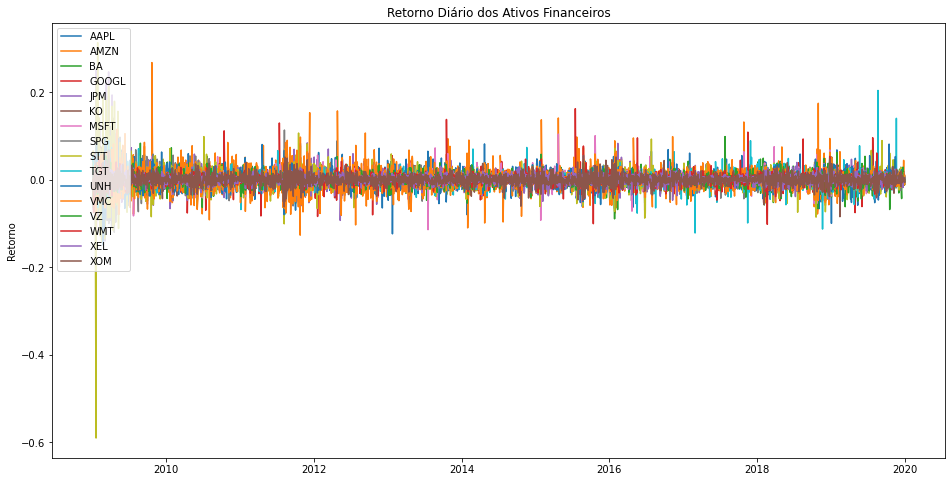

In [13]:
# Variáveis para manipulação dos dados

Stocks = 'dados/stocks.csv'
Data = pd.read_csv(Stocks)
Ticker = "ticker"

# Número de dias em que as ações são negociadas em um ano
Timeperiod = 252
num_trading_periods = Timeperiod
Data = Data[['Date', Ticker, 'Close']]

# Converte o formato de data
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Date'] = Data['Date'].dt.date

# Obtém o valor médio de fechamento para cada moeda de cada dia
Data = Data.groupby(['Date', Ticker])['Close'].agg('mean').reset_index()

# Pivot
Table = Data.pivot(index = 'Date', columns = Ticker, values = 'Close')

# Nomes das colunas
ColNames = Table.columns.values

# Retornos
Returns = Table.pct_change()

# Plot
plt.figure(figsize = (16, 8))
for Col in ColNames:
    plt.plot(Returns.index, Returns[Col], label = Col)
    
plt.ylabel('Retorno')
plt.legend(loc = 'upper left')
plt.title("Retorno Diário dos Ativos Financeiros")

In [14]:
# Variáveis de controle
CountPortfolio = 30000
RFF = 0.0178
AvgReturns = Returns.mean()
Covariance = Returns.cov()

In [15]:
# Gerando Portfólios
def EfficientFrontier(AvgReturns, Covariance, CountPortfolio, RFF):

    WeightHolder = []
    Res = np.zeros((3,CountPortfolio))
    
    for j in range(CountPortfolio):

        Wei = np.random.random(16)
        Wei /= np.sum(Wei)
        WeightHolder.append(Wei)

        Por_SD = np.sqrt(np.dot(Wei.T, np.dot(Covariance, Wei))) * np.sqrt(Timeperiod)
        Por_Return = np.sum(AvgReturns * Wei ) * Timeperiod

        Res[0,j] = Por_SD
        Res[1,j] = Por_Return
        Res[2,j] = (Por_Return - RFF) / Por_SD

    VolatilityIndexMin = np.argmin(Res[0])
    MinVolSD, MinVolReturn = Res[0,VolatilityIndexMin], Res[1,VolatilityIndexMin]
    MinVolAllocation = pd.DataFrame(WeightHolder[VolatilityIndexMin],index=Table.columns,columns=['Alloc'])
    MinVolAllocation.Alloc = [round(i*100,2)for i in MinVolAllocation.Alloc]
    MinVolAllocation = MinVolAllocation.T
    
    # O índice de Sharpe (Sharpe Ratio) foi desenvolvido pelo ganhador do Prêmio Nobel William F. Sharpe e 
    # é usado para ajudar os investidores a compreender o retorno de um investimento em comparação com seu risco.
    # O índice é o retorno médio obtido em excesso da taxa livre de risco por unidade de volatilidade ou risco total. 
    # A volatilidade é uma medida das flutuações de preço de um ativo ou portfólio.

    # Subtraindo a taxa livre de risco do retorno médio, o investidor pode isolar melhor os lucros associados às 
    # atividades de risco. A taxa de retorno livre de risco é o retorno de um investimento com risco zero, o que 
    # significa que é o retorno que os investidores poderiam esperar por não assumir riscos. O rendimento de um 
    # título do Tesouro, por exemplo, pode ser usado como a taxa livre de risco.

    SharpeIndexMax = np.argmax(Res[2])
    SDMaxSharpe, RetMaxSharpe = Res[0,SharpeIndexMax], Res[1,SharpeIndexMax]
    SharpeAllocationMax = pd.DataFrame(WeightHolder[SharpeIndexMax],index=Table.columns,columns=['Alloc'])
    SharpeAllocationMax.Alloc = [round(i*100,2)for i in SharpeAllocationMax.Alloc]
    SharpeAllocationMax = SharpeAllocationMax.T

    print("*" * 90)
    print("Alocação de Portfólio Para Volatilidade Mínima\n")
    print("Retorno Anual do Portfólio:", round(MinVolReturn,2))
    print("Volatilidade Anual do Portfólio", round(MinVolSD,2))
    print("\n")
    print(MinVolAllocation)

    print("*" * 90)
    print("Alocação de Portfólio Para Taxa de Sharpe Máxima\n")
    print("Retorno Anual do portfólio:", round(RetMaxSharpe,3))
    print("Volatilidade Anual do Portfólio", round(SDMaxSharpe,3))
    print("\n")
    print(SharpeAllocationMax)

    plt.figure(figsize=(14, 7))
    plt.savefig("mpt.png")
    plt.scatter(Res[0,:],Res[1,:],c=Res[2,:],cmap='YlGnBu', marker='o', s=6, alpha=0.5)
    plt.colorbar()
    plt.scatter(SDMaxSharpe,RetMaxSharpe, marker='*',color='g',s=300, label = 'Portfolio com Sharpe Máximo')
    plt.scatter(MinVolSD,MinVolReturn, marker='*',color='r',s=300, label = 'Portfolio com Volatilidade Mínima')
    plt.title('Teoria Moderna do Portfólio Usando a Teoria de Fronteira Eficiente')
    plt.xlabel('Volatilidade Anual')
    plt.ylabel('Retorno Anual')
    plt.legend(labelspacing=0.6)

******************************************************************************************
Alocação de Portfólio Para Volatilidade Mínima

Retorno Anual do Portfólio: 0.15
Volatilidade Anual do Portfólio 0.13


ticker  AAPL  AMZN    BA  GOOGL   JPM     KO  MSFT   SPG   STT   TGT   UNH  \
Alloc   5.02  5.34  1.12  10.24  3.14  14.03  1.07  1.51  1.73  2.13  3.02   

ticker   VMC     VZ    WMT    XEL   XOM  
Alloc   2.67  18.46  11.83  18.11  0.58  
******************************************************************************************
Alocação de Portfólio Para Taxa de Sharpe Máxima

Retorno Anual do portfólio: 0.238
Volatilidade Anual do Portfólio 0.181


ticker   AAPL   AMZN     BA  GOOGL   JPM    KO  MSFT   SPG   STT   TGT    UNH  \
Alloc   15.73  16.87  12.43   1.58  5.31  0.58  5.81  0.64  6.34  3.46  15.82   

ticker   VMC    VZ   WMT   XEL   XOM  
Alloc   1.53  2.65  4.24  5.99  1.02  


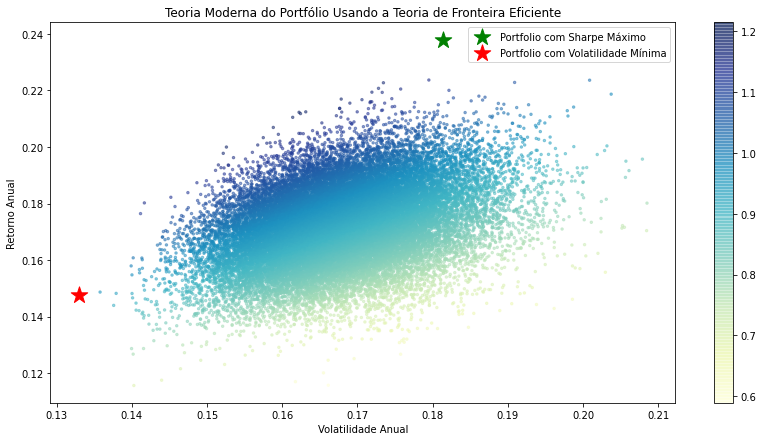

In [16]:
# Executa a função
EfficientFrontier(AvgReturns, Covariance, CountPortfolio, RFF)

# Fim